# Feature Selection in Uplift Modeling Using Booking Data

In this notebook we apply various stationary (non-dynamic) feature selection methods on some synthetic datasets

## [<span style="color:black; text-decoration:underline">1. Divergence Filter</span>](#First)  
* Kullback Leibler Divergence
* Euclidean Distance
* Chi-Squared Divergence

## [<span style="color:black; text-decoration:underline">2. Permutation with Uplift Random Forest</span>](#Second)

## [<span style="color:black; text-decoration:underline">3. Uplift Curve</span>](#Third)

## [<span style="color:black; text-decoration:underline">4. Net Information Value</span>](#Fourth)

#### Imports

In [1]:
from pyspark.sql import functions as F, types as T

from pysparkling import H2OContext, H2OConf

import h2o

from upliftml.datasets import simulate_randomized_trial
from upliftml.feature_selection.stationary_methods import (
    DivergenceFilter,
    PermutationUpliftRandomForestWrapper,
    UpliftCurveFilter,
    NetInformationValueFilter
)

#### Configurations

In [3]:
spark = (SparkSession
         .builder
         .enableHiveSupport()
         .getOrCreate()
         )

In [ ]:
def init_h2o():
    conf = (H2OConf()
            .setInternalClusterMode()
            .setCloudTimeout(12000)
           )
    context = H2OContext.getOrCreate(conf)
    return context

context = init_h2o()

#### Helper Functions

In [5]:
def plot_variable_contribution(feature_list, features_dict):
    num_rows = 4
    num_cols = 2
    figure, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    i = 0
    j = 0
    i = 0
    for row in range(num_rows):
        for col in range(num_cols):
            feature = feature_list[i]
            i += 1
            for k, v in features_dict[feature].items():
                x = str(round(k, 4)) if type(k) != str else k
                axes[row, col].bar(x, v)
                axes[row, col].set_title(feature)
    plt.xticks(rotation=45)
    plt.tight_layout()

In [6]:
def feature_importance_plot(df, feature_col='feature', score_col='score'):
    figure, axis = plt.subplots(figsize=(6, 6))
    
    # Sort the feature importances in ascending order
    df_asc = df.sort_values(by=score_col, ascending=True)

    axis.barh(df_asc[feature_col], df_asc[score_col])

## Create Synthetic Dataset

We create a synthetic dataset with 10 features. The first 5 features, that is, feature_1 - feature_5, determine the treatment heterogeneity and thus, are most important. The remaining features are unimportant.

In [7]:
df_pd = simulate_randomized_trial(n=10000, p=10, binary_outcome=True)
df_pd.columns = ['treatment', 'outcome', 'propensity', 'expected_outcome', 'actual_cate', 'feature_1_relevant',
                 'feature_2_relevant', 'feature_3_relevant', 'feature_4_relevant', 'feature_5_relevant',
                 'feature_6_irrelevant', 'feature_7_irrelevant', 'feature_8_irrelevant', 'feature_9_irrelevant',
                 'feature_10_irrelevant']
df_pd.drop(['propensity', 'expected_outcome', 'actual_cate'], axis=1, inplace=True)

In [8]:
df = spark.createDataFrame(df_pd)
df.limit(5).toPandas() 

,treatment,outcome,feature_1_relevant,feature_2_relevant,feature_3_relevant,feature_4_relevant,feature_5_relevant,feature_6_irrelevant,feature_7_irrelevant,feature_8_irrelevant,feature_9_irrelevant,feature_10_irrelevant
0,0,1,-0.084737,0.494273,0.992773,-1.116532,-0.362213,-1.644161,0.006040,0.632279,-0.362495,-1.698711
1,0,0,0.260781,-0.703103,0.614721,-1.321864,0.690738,1.811203,1.126038,-1.983999,0.101113,1.049233
2,1,1,0.424389,0.495972,-1.041702,-0.743752,-1.073801,-0.233339,-0.055330,-0.575487,1.246227,0.172168
3,0,1,-1.288333,-0.065929,-0.449530,-0.769518,0.006134,-0.528771,0.488077,-0.429006,-1.228511,-0.932345
4,1,1,-0.431252,0.929875,-0.035566,0.655417,0.460035,0.319067,-0.365895,-1.693721,1.034109,-1.356323


In [9]:
feature_names = df_pd.columns.to_list()[2:]

In [10]:
# Set the number of bins for bin-based feature selection methods globally
n_bins = 10

## <span id="First">1. Divergence Filter</span>

Use the Divergence Filter, proposed in Zhao et al. (2022), as a feature selection method. We can select different methods for calculating divergence, that is, either KL, ED, or Chi.

### 1.1 Kullback-Leibler Divergence

In [11]:
divergence_filter_kl = DivergenceFilter(n_bins=n_bins, method="KL")

In [12]:
fi_df_kl, fi_variables_df_kl = divergence_filter_kl.calculate_feature_importance(df, feature_names)

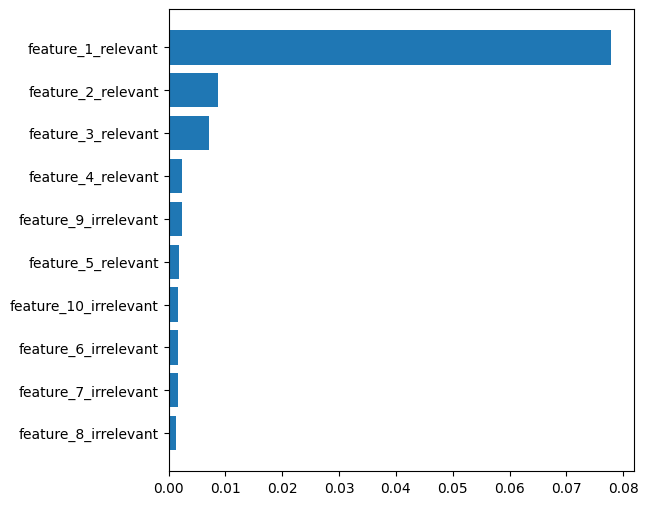

In [13]:
feature_importance_plot(fi_df_kl)

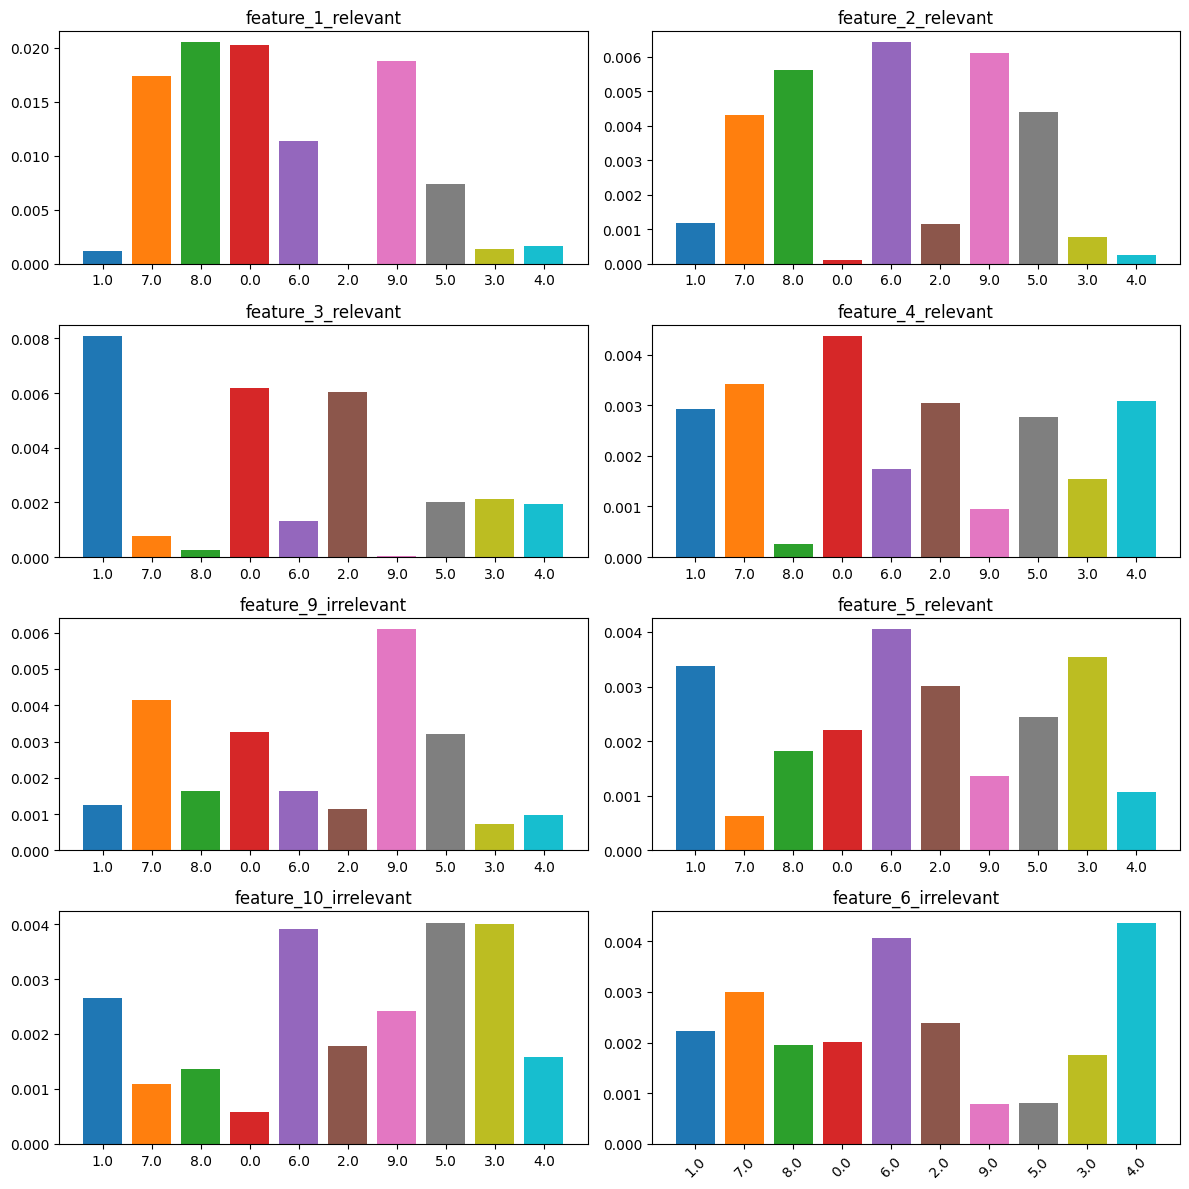

In [14]:
plot_variable_contribution(fi_df_kl.iloc[0:8, 0].to_list(), fi_variables_df_kl)

#### 1.2 Euclidean Distance

In [19]:
divergence_filter_ed = DivergenceFilter(n_bins=n_bins, method="ED")

In [20]:
fi_df_ed, fi_variables_df_ed = divergence_filter_ed.calculate_feature_importance(df, feature_names)

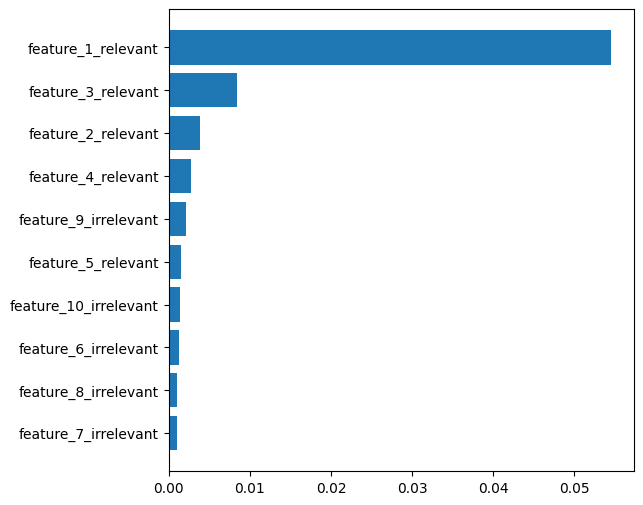

In [21]:
feature_importance_plot(fi_df_ed)

#### 1.3 Chi-Sqaured Divergence

In [22]:
divergence_filter_chi = DivergenceFilter(n_bins=n_bins, method="Chi")

In [23]:
fi_df_chi, fi_variables_df_chi = divergence_filter_chi.calculate_feature_importance(df, feature_names)

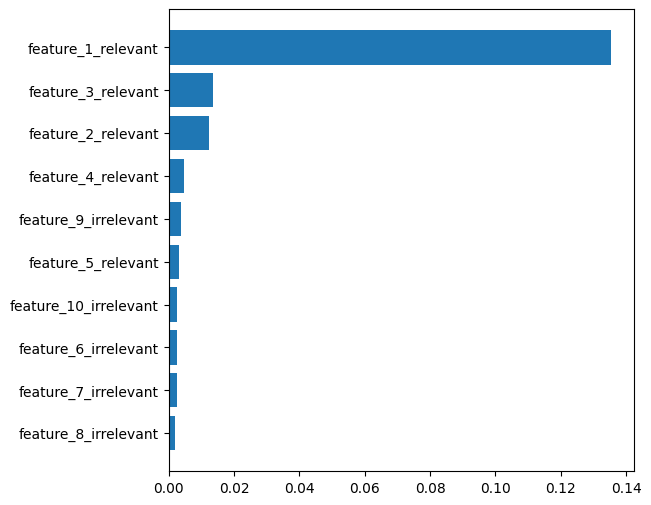

In [24]:
feature_importance_plot(fi_df_chi)

## <span id="Second">2. Permutation with Uplift Random Forest Wrapper</span>

Use the Permutation method with Uplift Random Forest as a wrapper feature selection method.

In [26]:
categorical_features = ['treatment', 'outcome']

In [30]:
# Hyperparameter for Distributed Uplift Random Forest
durf_dict = {
    'ntrees': 5,
    'max_depth': 5,
    'treatment_column': 'treatment',
    'uplift_metric': 'kl',  # Can either be 'kl', 'euclidean', or 'chi_squared'
    'nbins_top_level': 512,
    'nbins': 10,
    'min_rows': 1,
    'mtries': -1,
    'sample_rate': 0.5,
    'sample_rate_per_class': None,
    'col_sample_rate_per_tree': 0.5,
    'auuc_type': "qini",
    'auuc_nbins': 100,
    'ignore_const_cols': False
}

In [31]:
permutation_urf = PermutationUpliftRandomForestWrapper(durf_dict=durf_dict,
                                                       factor_list=categorical_features,
                                                       n_repeats=3)

In [32]:
fi_non_dynamicity_p = permutation_urf.calculate_feature_importance(context.asH2OFrame(df), feature_names)

upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%


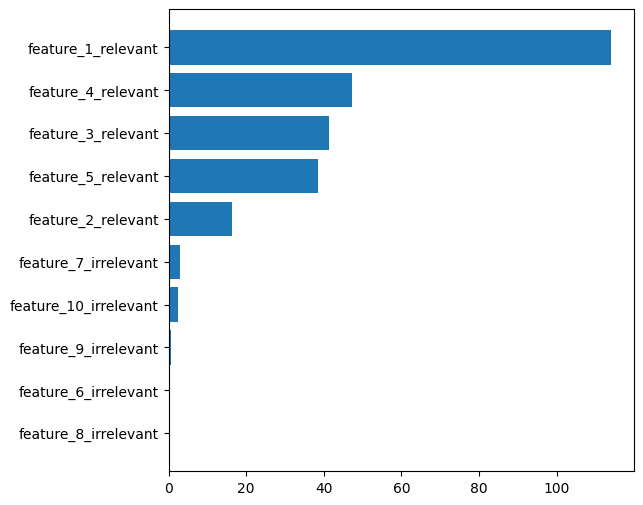

In [33]:
feature_importance_plot(fi_non_dynamicity_p)

## <span id="Third">3. Uplift Curve</span>

We are using the Filter method based on an uplift curve (Hu, 2022).

In [34]:
uplift_curve = UpliftCurveFilter(n_bins=n_bins)

In [35]:
fi_uc, fi_variables_uc = uplift_curve.calculate_feature_importance(df, feature_names)

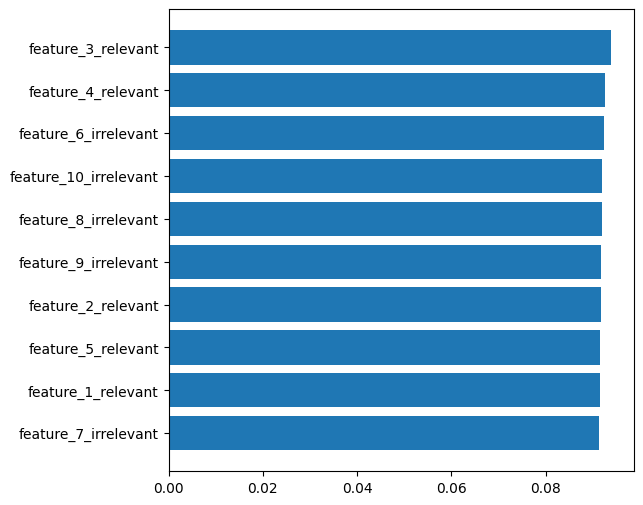

In [36]:
feature_importance_plot(fi_uc)

## <span id="Fourth">4. Net Information Value</span>

We are using the Net Information Value Filter Method (Larsen, 2010)

In [37]:
niv = NetInformationValueFilter(n_bins=n_bins)

In [38]:
fi_niv, fi_variables_niv = niv.calculate_feature_importance(df, feature_names)

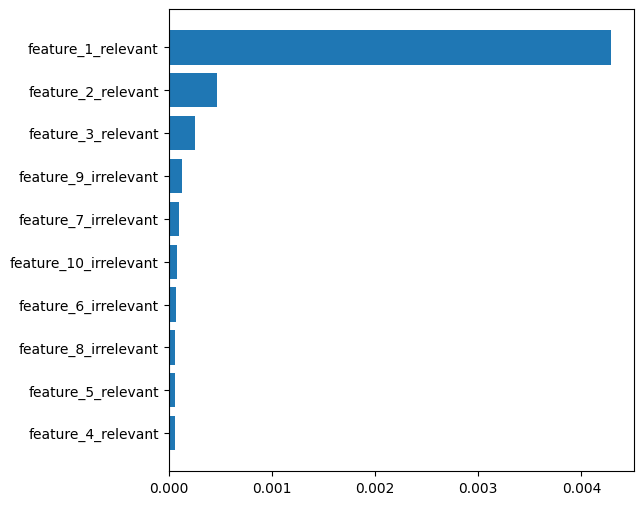

In [39]:
feature_importance_plot(fi_niv)

Done!